# Checking input and output folders

In [8]:
# 检查 /kaggle/working/ 目录
!ls /kaggle/working/

# 检查 /kaggle/input/ 目录
!ls /kaggle/input/

bdd10k	bdd10k.yaml  labels  runs  yolov5  yolov5n.yaml
bdd10k	yolo


# Copy BDD10K to the working folder

In [10]:
import shutil
import os

# 定义源目录和目标目录
source_dir = '/kaggle/input/bdd10k'
target_dir = '/kaggle/working'

# 确保目标目录存在
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# 拷贝整个目录树（包括所有文件和子目录）
shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)

print("文件拷贝完成！")

文件拷贝完成！


# Download YOLO Storage

In [4]:
# 克隆 YOLOv5 仓库
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# 安装依赖项
!pip install -r requirements.txt

# 安装 pycocotools（用于 mAP 计算）
!pip install pycocotools

fatal: destination path 'yolov5' already exists and is not an empty directory.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.0/973.0 kB 46.3 MB/s eta 0:00:00


In [10]:
# 检查 /kaggle/input/bdd10k/bdd10k/ 目录
!ls /kaggle/input/bdd10k/bdd10k/

# 检查 /kaggle/input/bdd10k/bdd10k/bdd10k_coco_labels/ 目录
!ls /kaggle/input/bdd10k/bdd10k/bdd10k_coco_labels/

# 检查图片目录（假设在 /kaggle/input/bdd10k/bdd10k/images/）
!ls /kaggle/input/bdd10k/bdd10k/images/

bdd10k_coco_labels  bdd10k_labels  bdd10k.yaml	images	labels
bdd10k_coco_labels_train.json  bdd10k_coco_labels_val.json
test  train  val


In [12]:
# 更新路径
coco_train_json = "/kaggle/input/bdd10k/bdd10k/bdd10k_coco_labels/bdd10k_coco_labels_train.json"
coco_val_json = "/kaggle/input/bdd10k/bdd10k/bdd10k_coco_labels/bdd10k_coco_labels_val.json"
image_train_dir = "/kaggle/input/bdd10k/bdd10k/images/train"
image_val_dir = "/kaggle/input/bdd10k/bdd10k/images/val"

# Convert JSON format lables to TXT format

In [13]:
import json
import os
from pathlib import Path
from pycocotools.coco import COCO

# 设置路径
coco_train_json = "/kaggle/input/bdd10k/bdd10k/bdd10k_coco_labels/bdd10k_coco_labels_train.json"
coco_val_json = "/kaggle/input/bdd10k/bdd10k/bdd10k_coco_labels/bdd10k_coco_labels_val.json"
output_train_labels = "/kaggle/working/labels/train"
output_val_labels = "/kaggle/working/labels/val"
image_train_dir = "/kaggle/input/bdd10k/bdd10k/images/train"
image_val_dir = "/kaggle/input/bdd10k/bdd10k/images/val"

# 创建输出目录
os.makedirs(output_train_labels, exist_ok=True)
os.makedirs(output_val_labels, exist_ok=True)

# 转换 COCO 格式到 YOLO 格式
def convert_coco_to_yolo(coco_json_path, image_dir, output_dir):
    coco = COCO(coco_json_path)
    categories = coco.loadCats(coco.getCatIds())
    category_map = {cat['id']: idx for idx, cat in enumerate(categories)}
    image_ids = coco.getImgIds()
    
    for img_id in image_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_width = img_info['width']
        img_height = img_info['height']
        img_filename = img_info['file_name']
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)
        yolo_labels = []
        for ann in annotations:
            bbox = ann['bbox']
            x_center = (bbox[0] + bbox[2] / 2) / img_width
            y_center = (bbox[1] + bbox[3] / 2) / img_height
            width = bbox[2] / img_width
            height = bbox[3] / img_height
            class_id = category_map[ann['category_id']]
            yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")
        txt_filename = Path(img_filename).stem + ".txt"
        txt_path = os.path.join(output_dir, txt_filename)
        with open(txt_path, 'w') as f:
            f.write("\n".join(yolo_labels))

# 转换训练集和验证集
convert_coco_to_yolo(coco_train_json, image_train_dir, output_train_labels)
convert_coco_to_yolo(coco_val_json, image_val_dir, output_val_labels)

print("标签转换完成！")

loading annotations into memory...
Done (t=1.50s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
标签转换完成！


# Comment
The YOLOV5 model does not have the ability to directly parse the JSON file of documents in COCO format. As a result, the bounding box in COCO format needs to be quasi-translated into a .txt file in YOLO format, which has a simple structure and is plain text in the format [class_id, x_center, y_center, width, height], which is easy for the model to be loaded and processed, and reduces the training workload


# Extract Class Information

In [14]:
# 提取类别信息
with open(coco_train_json, 'r') as f:
    coco_data = json.load(f)

categories = coco_data['categories']
category_names = [cat['name'] for cat in categories]
nc = len(category_names)

# 创建 bdd10k.yaml 文件
yaml_content = f"""
train: {image_train_dir}
val: {image_val_dir}
test: /kaggle/input/bdd10k/bdd10k/images/test

# 类别数量
nc: {nc}

# 类别名称
names: {category_names}
"""

with open("/kaggle/working/bdd10k.yaml", "w") as f:
    f.write(yaml_content)

print("bdd10k.yaml 文件已创建！")
print(f"类别数量: {nc}")
print(f"类别名称: {category_names}")

bdd10k.yaml 文件已创建！
类别数量: 10
类别名称: ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motor', 'bike', 'traffic light', 'traffic sign']


In [1]:
import os
from collections import defaultdict

# Set paths (consistent with previous code)
output_train_labels = "/kaggle/working/labels/train"
output_val_labels = "/kaggle/working/labels/val"

# Category names (obtained from previous output)
category_names = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motor', 'bike', 'traffic light', 'traffic sign']

# Initialize counter
def count_labels_in_directory(label_dir):
    # Use defaultdict to count the number of labels for each category
    label_counts = defaultdict(int)
    
    # Iterate through all .txt files in the label directory
    for txt_file in os.listdir(label_dir):
        if not txt_file.endswith('.txt'):
            continue
        txt_path = os.path.join(label_dir, txt_file)
        
        # Read the label file
        with open(txt_path, 'r') as f:
            lines = f.readlines()
        
        # Count the category for each line
        for line in lines:
            if line.strip():  # Ensure it's not an empty line
                class_id = int(line.split()[0])  # The first number is the category ID
                label_counts[class_id] += 1
    
    return label_counts

# Count the number of labels in the training and validation sets
train_label_counts = count_labels_in_directory(output_train_labels)
val_label_counts = count_labels_in_directory(output_val_labels)

# Print results
print("Training set label statistics:")
for class_id, count in train_label_counts.items():
    print(f"Category {category_names[class_id]} (ID: {class_id}): {count} labels")

print("\nValidation set label statistics:")
for class_id, count in val_label_counts.items():
    print(f"Category {category_names[class_id]} (ID: {class_id}): {count} labels")

# Print the total count for each category (even if some categories have no labels)
print("\nTotal count for each category (Training + Validation):")
for class_id, name in enumerate(category_names):
    train_count = train_label_counts.get(class_id, 0)
    val_count = val_label_counts.get(class_id, 0)
    total_count = train_count + val_count
    print(f"Category {name} (ID: {class_id}): {total_count} labels (Training: {train_count}, Validation: {val_count})")

# Count the total number of labels
total_train_labels = sum(train_label_counts.values())
total_val_labels = sum(val_label_counts.values())
print(f"\nTotal number of labels in training set: {total_train_labels}")
print(f"Total number of labels in validation set: {total_val_labels}")
print(f"Total number of labels: {total_train_labels + total_val_labels}")

Training set label statistics:
Category traffic light (ID: 8): 19053 labels
Category traffic sign (ID: 9): 24257 labels
Category car (ID: 2): 72089 labels
Category person (ID: 0): 8934 labels
Category truck (ID: 3): 3021 labels
Category rider (ID: 1): 457 labels
Category bike (ID: 7): 729 labels
Category bus (ID: 4): 1157 labels
Category motor (ID: 6): 291 labels
Category train (ID: 5): 14 labels

Validation set label statistics:
Category traffic light (ID: 8): 2740 labels
Category traffic sign (ID: 9): 3531 labels
Category car (ID: 2): 9987 labels
Category truck (ID: 3): 416 labels
Category person (ID: 0): 1234 labels
Category bus (ID: 4): 170 labels
Category rider (ID: 1): 60 labels
Category motor (ID: 6): 39 labels
Category bike (ID: 7): 111 labels
Category train (ID: 5): 2 labels

Total count for each category (Training + Validation):
Category person (ID: 0): 10168 labels (Training: 8934, Validation: 1234)
Category rider (ID: 1): 517 labels (Training: 457, Validation: 60)
Category 

In [15]:
# 检查 /kaggle/input/yolo/pytorch/default/1/ 目录
!ls /kaggle/input/yolo/pytorch/default/1/

yolov5n.pt  yolov5n.yaml


In [16]:
# 复制 yolov5n.yaml 到 /kaggle/working/
!cp /kaggle/input/yolo/pytorch/default/1/yolov5n.yaml /kaggle/working/yolov5n.yaml

# 确认文件
!ls /kaggle/working/

bdd10k	bdd10k.yaml  labels  runs  yolov5  yolov5n.yaml


# Create yolov5n.yaml

In [17]:
# 创建 yolov5n.yaml 文件
yaml_content = """
# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33
width_multiple: 0.25
anchors:
  - [10, 13, 16, 30, 33, 23]  # P3/8
  - [30, 61, 62, 45, 59, 119]  # P4/16
  - [116, 90, 156, 198, 373, 326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, C3, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
"""

with open("/kaggle/working/yolov5n.yaml", "w") as f:
    f.write(yaml_content)

print("yolov5n.yaml has been created in /kaggle/working/")

yolov5n.yaml has been created in /kaggle/working/


In [18]:
# 提取类别信息
coco_train_json = "/kaggle/input/bdd10k/bdd10k/bdd10k_coco_labels/bdd10k_coco_labels_train.json"
with open(coco_train_json, 'r') as f:
    import json
    coco_data = json.load(f)

categories = coco_data['categories']
nc = len(categories)  # 应该是 10

In [19]:
# 更新 nc
with open("/kaggle/working/yolov5n.yaml", "r") as f:
    yaml_content = f.read()

yaml_content = yaml_content.replace("nc: 80", f"nc: {nc}")

with open("/kaggle/working/yolov5n.yaml", "w") as f:
    f.write(yaml_content)

print(f"yolov5n.yaml updated with nc: {nc}")

yolov5n.yaml updated with nc: 10


# Comment
The labels of the BDD10K dataset are stored in COCO format, this code extracts the class information from the notebooks and matches the dataset, the YOLOv5 model needs to map the class_id to the specific class name via the ‘names’ field in the .yaml file, A yolo model without a .yaml file has no way of knowing the structure of the dataset, the number of categories, and their names, which can lead to training failures or errors.

# Training Models

In [20]:
!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 20 \
    --data /kaggle/working/bdd10k.yaml \
    --cfg /kaggle/working/yolov5n.yaml \
    --weights /kaggle/input/yolo/pytorch/default/1/yolov5n.pt \
    --name bdd10k_yolov5n \
    --project /kaggle/working/runs/train

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=/kaggle/input/yolo/pytorch/default/1/yolov5n.pt, cfg=/kaggle/working/yolov5n.yaml, data=/kaggle/working/bdd10k.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, re

# Comment
--img 640：It defines the size of the input image as 640x640 pixels.
--batch 16: it defines 16 images to be processed per training iteration.
--epochs 20: the dataset will be trained fully 20 times.
--weights /kaggle/input/yolo/pytorch/default/1/yolov5n.pt: it serves to load the pre-training weights file yolov5n.pt, which speeds up convergence and improves performance. This model is usually trained on the COCO dataset.


# Validate the model(Repeatable)

In [21]:
!python val.py \
    --img 640 \
    --data /kaggle/working/bdd10k.yaml \
    --weights /kaggle/working/runs/train/bdd10k_yolov5n/weights/best.pt \
    --task val \
    --project /kaggle/working/runs/val \
    --name exp

val: data=/kaggle/working/bdd10k.yaml, weights=['/kaggle/working/runs/train/bdd10k_yolov5n/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/kaggle/working/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.10.12 torch-1.11.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1772695 parameters, 0 gradients, 4.2 GFLOPs
val: Scanning /kaggle/input/bdd10k/bdd10k/labels/val... 1000 images, 0 backgroun
val: WARNING ⚠️ Cache directory /kaggle/input/bdd10k/bdd10k/labels is not writeable: [Errno 30] Read-only file system: '/kaggle/input/bdd10k/bdd10k/labels/val.cache.npy'
                 Class     Images  Instances          P          R      mAP50   
                   all       1000      18290      0.633      0.

# Comment
mAP@0.5=0.6852 and mAP@0.5:0.95=0.4152, which means that the overall performance of the model after training is moderately high, with good performance in categories such as car,people, but poor performance in categories such as rider,bike.It is possible to improve the validation performance of the model by increasing the training data and epoch or reducing the label.

In [15]:
!python detect.py \
    --img 640 \
    --source /kaggle/input/bdd10k/bdd10k/images/val/b1ca2e5d-84cf9134.jpg \
    --weights /kaggle/working/runs/train/bdd10k_yolov5n/weights/best.pt \
    --conf 0.25 \
    --project /kaggle/working/runs/detect \
    --name exp \
    --save-txt \
    --save-conf

detect: weights=['/kaggle/working/runs/train/bdd10k_yolov5n/weights/best.pt'], source=/kaggle/input/bdd10k/bdd10k/images/val/b1ca2e5d-84cf9134.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1772695 parameters, 0 gradients, 4.2 GFLOPs
image 1/1 /kaggle/input/bdd10k/bdd10k/images/val/b1ca2e5d-84cf9134.jpg: 384x640 9 persons, 6 cars, 5 traffic lights, 28.2ms
Speed: 0.5ms pre-process, 28.2ms inference, 144.5ms NMS per image at shape (1, 3, 640, 640)
Res

In [19]:
# 切换到正确的目录
%cd /kaggle/working/yolov5

# 确认当前目录
%pwd

/kaggle/working/yolov5


'/kaggle/working/yolov5'

# Detecting an image using the trained model

In [25]:
!python detect.py \
    --img 640 \
    --source /kaggle/input/bdd10k/bdd10k/images/val/b1ca2e5d-84cf9134.jpg \
    --weights /kaggle/working/runs/train/bdd10k_yolov5n/weights/best.pt \
    --conf 0.25 \
    --project /kaggle/working/runs/detect \
    --name exp \
    --save-txt \
    --save-conf

detect: weights=['/kaggle/working/runs/train/bdd10k_yolov5n/weights/best.pt'], source=/kaggle/input/bdd10k/bdd10k/images/val/b1ca2e5d-84cf9134.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1772695 parameters, 0 gradients, 4.2 GFLOPs
image 1/1 /kaggle/input/bdd10k/bdd10k/images/val/b1ca2e5d-84cf9134.jpg: 384x640 9 persons, 6 cars, 5 traffic lights, 28.5ms
Speed: 0.4ms pre-process, 28.5ms inference, 138.5ms NMS per image at shape (1, 3, 640, 640)
Res

# Checking the final processing results

In [26]:
# 检查推理结果
!ls /kaggle/working/runs/detect/exp3/

b1ca2e5d-84cf9134.jpg  labels


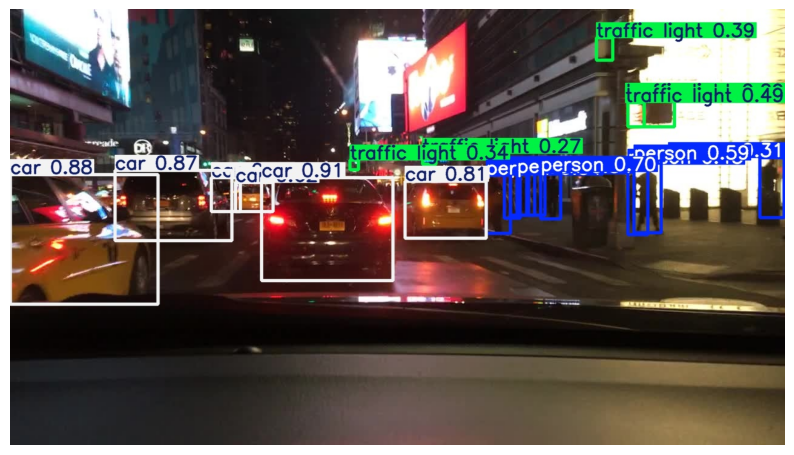

In [27]:
import cv2
import matplotlib.pyplot as plt

# 更新为实际生成的图片路径
result_image_path = "/kaggle/working/runs/detect/exp3/b1ca2e5d-84cf9134.jpg"
result_image = cv2.imread(result_image_path)

# 检查是否成功加载图片
if result_image is None:
    print(f"Failed to load image: {result_image_path}")
else:
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

# Comment
This step serves to load and visualise the detection results of the YOLOv5 model for a specific image, to visually check the performance of the model.

# Filtering of labels(Optional)

In [9]:
import os
from pathlib import Path

# Set paths (consistent with previous code)
output_train_labels = "/kaggle/working/labels/train"
output_val_labels = "/kaggle/working/labels/val"
filtered_train_labels = "/kaggle/working/labels_filtered/train"
filtered_val_labels = "/kaggle/working/labels_filtered/val"

# Original category names
category_names = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motor', 'bike', 'traffic light', 'traffic sign']

# Categories to keep and their original IDs
categories_to_keep = {'person': 0, 'car': 2, 'bike': 7}

# New category mapping (reassign IDs starting from 0)
new_category_map = {'person': 0, 'car': 1, 'bike': 2}
new_category_names = ['person', 'car', 'bike']

# Create filtered label directories
os.makedirs(filtered_train_labels, exist_ok=True)
os.makedirs(filtered_val_labels, exist_ok=True)

# Function to filter labels
def filter_labels(input_dir, output_dir):
    for txt_file in os.listdir(input_dir):
        if not txt_file.endswith('.txt'):
            continue
        input_path = os.path.join(input_dir, txt_file)
        output_path = os.path.join(output_dir, txt_file)
        
        # Read the original label file
        with open(input_path, 'r') as f:
            lines = f.readlines()
        
        # Filter and remap labels
        filtered_lines = []
        for line in lines:
            if not line.strip():  # Skip empty lines
                continue
            class_id = int(line.split()[0])
            # Check if the class_id corresponds to a category we want to keep
            for cat_name, old_id in categories_to_keep.items():
                if class_id == old_id:
                    new_id = new_category_map[cat_name]
                    # Replace the old class_id with the new one
                    new_line = f"{new_id} {' '.join(line.split()[1:])}\n"
                    filtered_lines.append(new_line)
                    break
        
        # Write the filtered labels to a new file
        if filtered_lines:  # Only write if there are labels to keep
            with open(output_path, 'w') as f:
                f.writelines(filtered_lines)

# Filter training and validation labels
filter_labels(output_train_labels, filtered_train_labels)
filter_labels(output_val_labels, filtered_val_labels)

print("Label filtering completed!")

# Update bdd10k.yaml file
image_train_dir = "/kaggle/input/bdd10k/bdd10k/images/train"
image_val_dir = "/kaggle/input/bdd10k/bdd10k/images/val"

# Create new bdd10k.yaml content
yaml_content = f"""
train: {image_train_dir}
val: {image_val_dir}
test: /kaggle/input/bdd10k/bdd10k/images/test

# Number of classes
nc: {len(new_category_names)}

# Class names
names: {new_category_names}
"""

# Write the updated bdd10k.yaml file
with open("/kaggle/working/bdd10k_filtered.yaml", "w") as f:
    f.write(yaml_content)

print("Updated bdd10k_filtered.yaml file created!")
print(f"Number of classes: {len(new_category_names)}")
print(f"Class names: {new_category_names}")

Label filtering completed!
Updated bdd10k_filtered.yaml file created!
Number of classes: 3
Class names: ['person', 'car', 'bike']


In [10]:
import os
from pathlib import Path
from collections import defaultdict

# Set paths
output_train_labels = "/kaggle/working/labels/train"
output_val_labels = "/kaggle/working/labels/val"
filtered_train_labels = "/kaggle/working/labels_filtered/train"
filtered_val_labels = "/kaggle/working/labels_filtered/val"

# Original category names (for reference)
category_names = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motor', 'bike', 'traffic light', 'traffic sign']

# Categories to keep and their original IDs
categories_to_keep = {'person': 0, 'car': 2, 'bike': 7}

# New category mapping (reassign IDs starting from 0)
new_category_map = {'person': 0, 'car': 1, 'bike': 2}
new_category_names = ['person', 'car', 'bike']

# Create filtered label directories
os.makedirs(filtered_train_labels, exist_ok=True)
os.makedirs(filtered_val_labels, exist_ok=True)

# Function to filter labels
def filter_labels(input_dir, output_dir):
    invalid_label_counts = defaultdict(int)  # To count invalid labels by class
    for txt_file in os.listdir(input_dir):
        if not txt_file.endswith('.txt'):
            continue
        input_path = os.path.join(input_dir, txt_file)
        output_path = os.path.join(output_dir, txt_file)
        
        # Read the original label file
        with open(input_path, 'r') as f:
            lines = f.readlines()
        
        # Filter and remap labels
        filtered_lines = []
        for line in lines:
            if not line.strip():  # Skip empty lines
                continue
            class_id = int(line.split()[0])
            # Check if the class_id corresponds to a category we want to keep
            found = False
            for cat_name, old_id in categories_to_keep.items():
                if class_id == old_id:
                    new_id = new_category_map[cat_name]
                    # Replace the old class_id with the new one
                    new_line = f"{new_id} {' '.join(line.split()[1:])}\n"
                    filtered_lines.append(new_line)
                    found = True
                    break
            if not found:
                invalid_label_counts[class_id] += 1
        
        # Write the filtered labels to a new file
        if filtered_lines:  # Only write if there are labels to keep
            with open(output_path, 'w') as f:
                f.writelines(filtered_lines)
    
    # Print the count of invalid labels by class
    if invalid_label_counts:
        print("Count of invalid labels by class:")
        for class_id, count in invalid_label_counts.items():
            print(f"Class {category_names[class_id]} (ID: {class_id}): {count} labels")
    else:
        print("No invalid labels found.")

    return invalid_label_counts

# Filter training and validation labels
print("Filtering training labels...")
train_invalid_counts = filter_labels(output_train_labels, filtered_train_labels)
print("\nFiltering validation labels...")
val_invalid_counts = filter_labels(output_val_labels, filtered_val_labels)

# Combine counts for total statistics
total_invalid_counts = defaultdict(int)
for class_id, count in train_invalid_counts.items():
    total_invalid_counts[class_id] += count
for class_id, count in val_invalid_counts.items():
    total_invalid_counts[class_id] += count

# Print total counts
print("\nTotal count of invalid labels (Training + Validation):")
for class_id, count in total_invalid_counts.items():
    print(f"Class {category_names[class_id]} (ID: {class_id}): {count} labels (Training: {train_invalid_counts.get(class_id, 0)}, Validation: {val_invalid_counts.get(class_id, 0)})")

# List of invalid classes (the other 7 classes)
invalid_classes = ['rider', 'truck', 'bus', 'train', 'motor', 'traffic light', 'traffic sign']
print("\nSummary of invalid classes:")
for class_name in invalid_classes:
    class_id = category_names.index(class_name)
    count = total_invalid_counts.get(class_id, 0)
    print(f"Class {class_name} (ID: {class_id}): {count} labels")

print("\nLabel filtering completed!")

Filtering training labels...
Count of invalid labels by class:
Class traffic light (ID: 8): 19053 labels
Class traffic sign (ID: 9): 24257 labels
Class truck (ID: 3): 3021 labels
Class rider (ID: 1): 457 labels
Class bus (ID: 4): 1157 labels
Class motor (ID: 6): 291 labels
Class train (ID: 5): 14 labels

Filtering validation labels...
Count of invalid labels by class:
Class traffic light (ID: 8): 2740 labels
Class traffic sign (ID: 9): 3531 labels
Class truck (ID: 3): 416 labels
Class bus (ID: 4): 170 labels
Class rider (ID: 1): 60 labels
Class motor (ID: 6): 39 labels
Class train (ID: 5): 2 labels

Total count of invalid labels (Training + Validation):
Class traffic light (ID: 8): 21793 labels (Training: 19053, Validation: 2740)
Class traffic sign (ID: 9): 27788 labels (Training: 24257, Validation: 3531)
Class truck (ID: 3): 3437 labels (Training: 3021, Validation: 416)
Class rider (ID: 1): 517 labels (Training: 457, Validation: 60)
Class bus (ID: 4): 1327 labels (Training: 1157, Vali

# Confirmation label successfully filtered

In [11]:
import os

# Check filtered labels
def check_labels(label_dir):
    invalid_labels = []
    for txt_file in os.listdir(label_dir):
        if not txt_file.endswith('.txt'):
            continue
        txt_path = os.path.join(label_dir, txt_file)
        with open(txt_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if not line.strip():
                continue
            class_id = int(line.split()[0])
            if class_id not in [0, 1, 2]:  # Only allow 0, 1, 2
                invalid_labels.append((txt_file, class_id))

    if invalid_labels:
        print("Invalid labels found:")
        for file, class_id in invalid_labels:
            print(f"File: {file}, Invalid class ID: {class_id}")
    else:
        print("All labels are valid!")

# Check training and validation labels
check_labels(filtered_train_labels)
check_labels(filtered_val_labels)

All labels are valid!
All labels are valid!


# Comment
The filter labels serve to simplify the dataset, improve the validation performance of the model, and reduce the complexity of the model. This project requires the YOLOv5 model to run on a lightweight host, JetsonNano, so filtering the labels is also a key step in achieving the project's goals